In [1]:
    import pickle

import numpy as np
import pandas as pd
import scipy.stats as ss
from sklearn.model_selection import train_test_split, KFold

import src.utils as utils
from src import *

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_corr(cols):
    cols_ = [col for col in problem_data.df.columns if any([c.lower() in col.lower() for c in cols])]
    print(cols_)
    cov_matrix = problem_data.df[cols_].corr()

    # Plotting the covariance matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(cov_matrix, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Covariance Matrix')
    plt.show()

In [3]:



def ploy_feature_importance_non_aggregated(model, problem_data):
    feature_importance = model._model.feature_importances_
    df_feature_importance = pd.DataFrame(
        {"feature": problem_data.df_X.columns, "importance": feature_importance}
    )

    df_feature_importance = df_feature_importance.sort_values("importance", ascending=False)
    df_feature_importance = df_feature_importance[df_feature_importance["importance"] > 0.01]
    df_feature_importance.plot(kind="bar", x="feature", y="importance")


def plot_feature_importance(model, problem_data, feature_names):
    _feature_importance = model._model.feature_importances_
    feature_importance = [
        sum(_feature_importance[[i for i, col in enumerate(problem_data.df_X.columns) if feature_name in col]])
        for feature_name in feature_names
    ]

    df_feature_importance = pd.DataFrame(
        {"feature": feature_names, "importance": feature_importance}
    )

    df_feature_importance = df_feature_importance.sort_values("importance", ascending=False)
    df_feature_importance.plot(kind="bar", x="feature", y="importance")


def print_metrics(model, test_X_df: pd.DataFrame, test_y_df: pd.DataFrame, df_original: pd.DataFrame):
    dfs_sexes = {}
    dfs_races = {}
    male_indices = np.intersect1d(df_original[df_original["sex"] == "Male"].index, test_X_df.index)
    female_indices = np.intersect1d(df_original[df_original["sex"] != "Male"].index, test_X_df.index)

    white_indices = np.intersect1d(df_original[df_original["race"] == "White"].index, test_X_df.index)
    other_indices = np.intersect1d(df_original[df_original["race"] != "White"].index, test_X_df.index)

    dfs_sexes["Male"] = (test_X_df.loc[male_indices], test_y_df.loc[male_indices])

    dfs_sexes["Female"] = (test_X_df.loc[female_indices], test_y_df.loc[female_indices])

    dfs_races["White"] = (test_X_df.loc[white_indices], test_y_df.loc[white_indices])

    dfs_races["Other"] = (test_X_df.loc[other_indices], test_y_df.loc[other_indices])

    results_df_sex = pd.DataFrame(columns=["Sex", "Accuracy", "TPR", "TNR"])
    for (i), (X, y) in dfs_sexes.items():
        acc = utils.calculate_accuracy_score(model, X.values, y.values.reshape(-1))
        precision = utils.calculate_tpr_score(model, X.values, y.values.reshape(-1))
        recall = utils.calculate_tnr_score(model, X.values, y.values.reshape(-1))
        row = [i,
               acc, precision, recall]
        results_df_sex.loc[len(results_df_sex)] = row

    results_df_race = pd.DataFrame(columns=["Race", "Accuracy", "TPR", "TNR"])
    for (i), (X, y) in dfs_races.items():
        acc = utils.calculate_accuracy_score(model, X.values, y.values.reshape(-1))
        precision = utils.calculate_tpr_score(model, X.values, y.values.reshape(-1))
        recall = utils.calculate_tnr_score(model, X.values, y.values.reshape(-1))
        row = [i,
               acc, precision, recall]
        results_df_race.loc[len(results_df_race)] = row

    print_df_as_latex(results_df_sex)
    print_df_as_latex(results_df_race)


def train_model(model: type, features_to_exclude: list[str], params:dict = {}):
    problem_data = ProblemData(features_to_exclude)

    train_X_df, test_X_df, train_y_df, test_y_df = train_test_split(
        problem_data.df_X, problem_data.df_y, test_size=0.2, random_state=42,
        shuffle=True
    )

    train_X = train_X_df.values
    test_X = test_X_df.values
    train_y = train_y_df.values.reshape(-1)
    test_y = test_y_df.values.reshape(-1)
    train_X, train_y, test_X, test_y = utils.process_data(train_X, train_y, test_X, test_y)
    
    train_X_df[train_X_df.columns] = train_X
    test_X_df[test_X_df.columns] = test_X
    train_y_df[train_y_df.columns] = train_y.reshape(-1, 1)
    test_y_df[test_y_df.columns] = test_y.reshape(-1, 1)

    model = model(params)
    model.fit(train_X, train_y)
    
    print_metrics(model, test_X_df, test_y_df, problem_data.original_df)

    print("Accuracy: ", utils.calculate_accuracy_score(model, test_X, test_y))
    print("Precision (TPR): ", utils.calculate_tpr_score(model, test_X, test_y))

    return model, problem_data, train_X_df, train_y_df, test_X_df, test_y_df
    

def cramers_v(col1, col2):
    confusion_matrix = pd.crosstab(col1, col2).values

    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))


def compute_cramers_v_matrix(df: pd.DataFrame, columns: list[str]):
    corr_matrix = pd.DataFrame(index=columns, columns=columns)
    for col1 in columns:
        for col2 in columns:
            corr_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])
    return corr_matrix.astype(float)


def plot_cramers_v_matrix(df: pd.DataFrame, columns: list[str]):
    corr_matrix = compute_cramers_v_matrix(df, columns)
    plt.figure(figsize=(10, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Cramers V Matrix')
    plt.show()
    
def print_df_as_latex(df: pd.DataFrame):
    # format floating point numbers
    print(" & ".join(list(df.columns)))
    for i, row in df.iterrows():
        print(" & ".join([f"{x:.2f}" if isinstance(x, float) else str(x) for x in row.values]) + " \\\\")
        
def cross_validate(model: type, features_to_exclude: list[str], params:dict = {}):
    def test_and_return_score(problem_data: ProblemData, model_name: type, train_indices: np.array, test_indices: np.array,
                              error_metric: callable) -> np.float64:
        train_X, train_Y = (problem_data.df_X.values[train_indices],
                            problem_data.df_y.values[train_indices])
        train_Y = train_Y.reshape(-1)

        test_X, test_Y = (problem_data.df_X.values[test_indices],
                          problem_data.df_y.values[test_indices])
        test_Y = test_Y.reshape(-1)

        train_X, train_Y, test_X, test_Y = utils.process_data(train_X, train_Y, test_X, test_Y)

        model = model_name(params)
        model.fit(train_X, train_Y)

        return error_metric(model, test_X, test_Y)
    
    problem_data = ProblemData(features_to_exclude)
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    data_sets = list(KFold(n_splits=5, shuffle=True, random_state=42)
                         .split(problem_data.df_X, problem_data.df_y))
    accs = []
    tprs = []
    tnrs = []
    for train_indices, test_indices in data_sets:
        accs.append(test_and_return_score(problem_data, model, train_indices, test_indices, utils.calculate_accuracy_score))
        tprs.append(test_and_return_score(problem_data, model, train_indices, test_indices, utils.calculate_tpr_score))
        tnrs.append(test_and_return_score(problem_data, model, train_indices, test_indices, utils.calculate_tnr_score))
        
    print("Accuracy: ", np.mean(accs))
    print("TPR: ", np.mean(tprs))
    print("TNR: ", np.mean(tnrs))
    

In [4]:
model, problem_data, train_X, train_y, test_X, test_y = train_model(XGBoost, [], {})
original_df = problem_data.original_df

print("Accuracy: ", utils.calculate_accuracy_score(model, test_X.values, test_y.values.reshape(-1)))
print("F1: ", utils.calculate_f1_score(model, test_X.values, test_y.values.reshape(-1)))
print("ROC AUC: ", utils.calculate_auc_score(model, test_X.values, test_y.values.reshape(-1)))

Sex & Accuracy & TPR & TNR
Male & 0.84 & 0.79 & 0.92 \\
Female & 0.93 & 0.78 & 0.98 \\
Race & Accuracy & TPR & TNR
White & 0.86 & 0.78 & 0.94 \\
Other & 0.92 & 0.84 & 0.98 \\
Accuracy:  0.8677165354330708
Precision (TPR):  0.7871001573151547
Accuracy:  0.8677165354330708
F1:  0.7043641482871891
ROC AUC:  0.7903712389734296


In [5]:
# percentage of men that have income >50K
print("Percentage of men >50k", original_df[original_df["sex"] == "Male"]["income"].value_counts(normalize=True)[">50K"])
print("Percentage of woman >50k", original_df[original_df["sex"] == "Female"]["income"].value_counts(normalize=True)[">50K"])

Percentage of men >50k 0.3037672281776417
Percentage of woman >50k 0.10925148221343874


In [6]:
print("Percentage of white >50k", original_df[original_df["race"] == "White"]["income"].value_counts(normalize=True)[">50K"])
print("Percentage of other >50k", original_df[original_df["race"] != "White"]["income"].value_counts(normalize=True)[">50K"])

Percentage of white >50k 0.2539868780230832
Percentage of other >50k 0.15254237288135594


In [7]:
surrogate_model = DecisionTreeSurrogate(model, {"max_depth": 3})
surrogate_model.fit(train_X.values, train_y.values.reshape(-1))

print("Performance in mimicking XGBoost model")
print("Accuracy: ", utils.calculate_accuracy_score(surrogate_model, test_X.values, model.predict(test_X.values)))
print("F1: ", utils.calculate_f1_score(surrogate_model, test_X.values, model.predict(test_X.values)))
print("ROC AUC: ", utils.calculate_auc_score(surrogate_model, test_X.values, model.predict(test_X.values)))

print_metrics(surrogate_model, test_X, pd.DataFrame(columns=["income"], data=model.predict(test_X.values).reshape(-1, 1), index=test_y.index), problem_data.original_df)

Performance in mimicking XGBoost model
Accuracy:  0.916745406824147
F1:  0.7738808098089536
ROC AUC:  0.8398453735343513
Sex & Accuracy & TPR & TNR
Male & 0.89 & 0.85 & 0.95 \\
Female & 0.96 & 0.86 & 0.99 \\
Race & Accuracy & TPR & TNR
White & 0.91 & 0.85 & 0.97 \\
Other & 0.95 & 0.79 & 0.98 \\


In [8]:
print("Performance in predicting dataset")
print("Accuracy: ", utils.calculate_accuracy_score(surrogate_model, test_X.values, test_y.values.reshape(-1)))
print("F1: ", utils.calculate_f1_score(surrogate_model, test_X.values, test_y.values.reshape(-1)))
print("ROC AUC: ", utils.calculate_auc_score(surrogate_model, test_X.values, test_y.values.reshape(-1)))

print_metrics(surrogate_model, test_X, test_y, problem_data.original_df)

Performance in predicting dataset
Accuracy:  0.8413648293963255
F1:  0.6179519595448799
ROC AUC:  0.7330881503788788
Sex & Accuracy & TPR & TNR
Male & 0.80 & 0.76 & 0.92 \\
Female & 0.93 & 0.80 & 0.99 \\
Race & Accuracy & TPR & TNR
White & 0.83 & 0.77 & 0.94 \\
Other & 0.89 & 0.73 & 0.97 \\


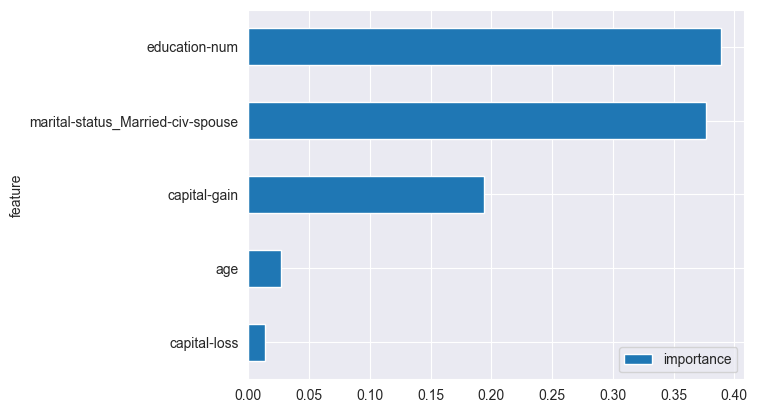

In [9]:
surrogate_model.plot_feature_importance(problem_data.df_X.columns)

In [10]:
surrogate_model.print_decision_paths(problem_data.df_X.columns)

      Leaf(3): marital-status_Married-civ-spouse <= 0.50 AND capital-gain <= 0.07 AND capital-loss <= 0.54 -> Predict = [0.99, 0.01], Samples per class = [0.98680279 0.01319721], Total samples = 20080
      Leaf(10): marital-status_Married-civ-spouse > 0.50 AND education-num <= 0.70 AND capital-gain <= 0.05 -> Predict = [0.83, 0.17], Samples per class = [0.82911562 0.17088438], Total samples = 11183
      Leaf(11): marital-status_Married-civ-spouse > 0.50 AND education-num <= 0.70 AND capital-gain > 0.05 -> Predict = [0.02, 0.98], Samples per class = [0.01929825 0.98070175], Total samples = 570
      Leaf(14): marital-status_Married-civ-spouse > 0.50 AND education-num > 0.70 AND age > 0.14 -> Predict = [0.17, 0.83], Samples per class = [0.17199282 0.82800718], Total samples = 5570


In [11]:
model, problem_data, train_X, train_y, test_X, test_y = train_model(DecisionTree, [], {"max_depth": 3, "random_state": 42})

Sex & Accuracy & TPR & TNR
Male & 0.80 & 0.77 & 0.93 \\
Female & 0.93 & 0.81 & 0.99 \\
Race & Accuracy & TPR & TNR
White & 0.83 & 0.78 & 0.95 \\
Other & 0.89 & 0.75 & 0.97 \\
Accuracy:  0.8403149606299213
Precision (TPR):  0.7736220472440944


In [12]:
cross_validate(DecisionTree, [], {"max_depth": 3})

Accuracy:  0.8423595061957029
TPR:  0.7599578900194339
TNR:  0.948336249366865


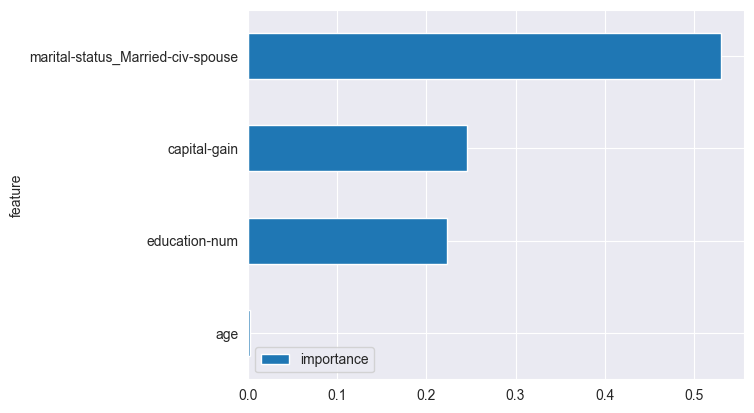

In [13]:
model: DecisionTree
model.plot_feature_importance(problem_data.df_X.columns)

In [14]:
model.print_decision_paths(problem_data.df_X.columns)

      Leaf(3): marital-status_Married-civ-spouse <= 0.50 AND capital-gain <= 0.07 AND education-num <= 0.77 -> Predict = [0.98, 0.02], Samples per class = [0.97575308 0.02424692], Total samples = 16167
      Leaf(4): marital-status_Married-civ-spouse <= 0.50 AND capital-gain <= 0.07 AND education-num > 0.77 -> Predict = [0.86, 0.14], Samples per class = [0.85685585 0.14314415], Total samples = 3982
      Leaf(10): marital-status_Married-civ-spouse > 0.50 AND education-num <= 0.77 AND capital-gain <= 0.05 -> Predict = [0.7, 0.3], Samples per class = [0.70064075 0.29935925], Total samples = 11705
      Leaf(11): marital-status_Married-civ-spouse > 0.50 AND education-num <= 0.77 AND capital-gain > 0.05 -> Predict = [0.02, 0.98], Samples per class = [0.0180624 0.9819376], Total samples = 609
      Leaf(13): marital-status_Married-civ-spouse > 0.50 AND education-num > 0.77 AND capital-gain <= 0.05 -> Predict = [0.33, 0.67], Samples per class = [0.33348204 0.66651796], Total samples = 4483
 

In [15]:
model, problem_data, train_X, train_y, test_X, test_y = train_model(LogRegression, [], {"penalty": "l2"})

print("Accuracy: ", utils.calculate_accuracy_score(model, test_X.values, test_y.values.reshape(-1)))
print("F1: ", utils.calculate_f1_score(model, test_X.values, test_y.values.reshape(-1)))
print("ROC AUC: ", utils.calculate_auc_score(model, test_X.values, test_y.values.reshape(-1)))

Sex & Accuracy & TPR & TNR
Male & 0.81 & 0.75 & 0.91 \\
Female & 0.93 & 0.78 & 0.98 \\
Race & Accuracy & TPR & TNR
White & 0.84 & 0.75 & 0.93 \\
Other & 0.90 & 0.76 & 0.97 \\
Accuracy:  0.8472440944881889
Precision (TPR):  0.7505567928730512
Accuracy:  0.8472440944881889
F1:  0.6494820525174657
ROC AUC:  0.7549582922474215


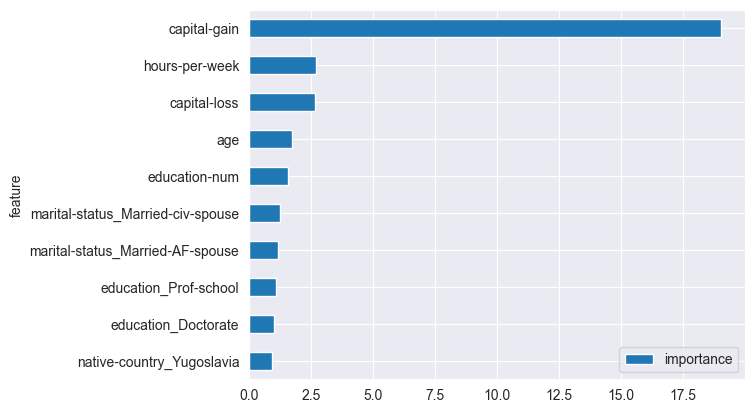

In [16]:
model.plot_feature_importance(problem_data.df_X.columns, 10)